In [1]:
# %pip install -q causal-learn

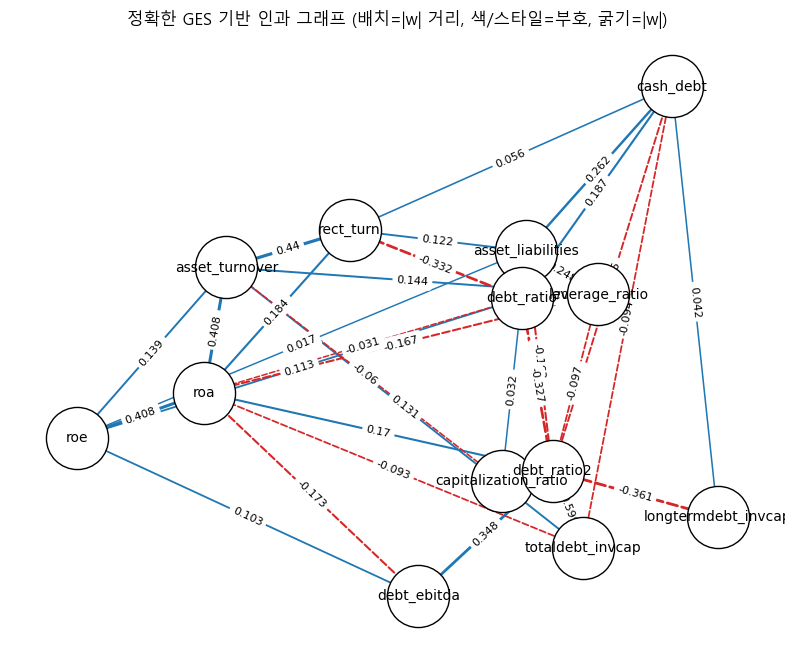

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# causal-learn: 정확한 GES 구현
from causallearn.search.ScoreBased.GES import ges   # 기본 점수는 BIC
# from causallearn.score.LocalScoreFunction import local_score_BIC

# 한글 폰트/마이너스 설정(선택)
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# 0) 데이터 로드 (기존과 동일)
df = pd.read_csv("training_data.csv")
feature_cols = df.drop(columns=["Unnamed: 0", "label"]).columns
X_base = df[feature_cols].copy()
y = df["label"].astype(int)
cols_for_w = list(feature_cols)
cols = cols_for_w  # 시각화 라벨 호환

# 1) 정확한 GES 실행 (기본 BIC 점수 사용)
X_np = X_base.values.astype(float)
Record = ges(X_np)  # 또는 Record = ges(X_np, score_func='local_score_BIC')
Gmat = Record['G'].graph  # orientation 행렬 (numpy.ndarray)
# 문서: G.graph[j,i]=1 & G.graph[i,j]=-1 이면 i -> j (i가 부모, j가 자식)

# 2) 방향성 인접행렬 A (i <- j 형태로 저장하기 위해 A[child, parent]=1)
p = len(cols_for_w)
A = np.zeros((p, p), dtype=float)
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        # i -> j ?
        if (Gmat[j, i] == 1) and (Gmat[i, j] == -1):
            A[j, i] = 1.0  # child=j, parent=i

# 3) 표준화 OLS로 엣지 가중치 행렬 W (i <- j)
Z = StandardScaler().fit_transform(X_np)
W = np.zeros_like(A, dtype=float)
for child in range(p):
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue
    y_child = Z[:, child]
    X_par = Z[:, parents]
    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)  # 절편 없음(표준화)
    W[child, parents] = coef.astype(float)

# ============ 여기부터 시각화 개선(음수 가중치 지원) ============

# 시각화 임계 설정
USE_QUANTILE = False      # 분위수 임계 사용 여부
W_THRESHOLD = 0.01        # 고정 임계(|W|>0.01)
W_ABS_QUANTILE = 0.90     # 상위 10%만 (USE_QUANTILE=True일 때 사용)

TOP_K_EDGES = None        # 상위 |w| 간선만 표시하고 싶으면 정수(예: 100)로 설정

def get_threshold(W, fixed=W_THRESHOLD, use_q=USE_QUANTILE, q=W_ABS_QUANTILE):
    if not use_q:
        return fixed
    aw = np.abs(W).ravel()
    aw = aw[aw > 0]
    return float(np.quantile(aw, q)) if aw.size else fixed

thr = get_threshold(W)

# 4) 임계 적용 + (선택) 상위 K개 필터 → DiGraph 구성
edges_all = []
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        w = float(W[i, j])
        if abs(w) > thr:
            edges_all.append((cols[j], cols[i], w))  # parent -> child, weight=w

# 상위 K개만 표시(선택)
if TOP_K_EDGES is not None and TOP_K_EDGES > 0 and len(edges_all) > TOP_K_EDGES:
    edges_all = sorted(edges_all, key=lambda t: abs(t[2]), reverse=True)[:TOP_K_EDGES]

G = nx.DiGraph()
for u, v, w in edges_all:
    G.add_edge(u, v, weight=round(w, 3))

# ---- 배치: 음수 가중치 문제 해결 (거리=1/(|w|+ε)로 양의 거리 그래프 H 구성)
eps = 1e-6
H = nx.Graph()  # 레이아웃 전용 보조 그래프(무향 + 양의 거리)
for u, v, d in G.edges(data=True):
    w = d.get("weight", 0.0)
    dist = 1.0 / (abs(w) + eps)   # |w| 클수록 더 가까워지도록
    H.add_edge(u, v, weight=dist)

pos = nx.kamada_kawai_layout(H, weight='weight')  # 안정적 배치

# ---- 스타일: 부호/크기 시각화
max_abs = max((abs(d["weight"]) for _, _, d in G.edges(data=True)), default=1.0)
pos_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] >= 0]
neg_edges = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] < 0]
pos_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in pos_edges]
neg_widths = [1.0 + 3.0 * abs(G[u][v]["weight"]) / max_abs for u, v in neg_edges]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="white", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=10)

# 양수: 파란 실선 / 음수: 빨간 점선
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color="tab:blue", width=pos_widths, arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color="tab:red",  width=neg_widths, style="dashed", arrows=True)

# 원래 가중치 라벨(부호 유지)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=8)
plt.title("정확한 GES 기반 인과 그래프 (배치=|w| 거리, 색/스타일=부호, 굵기=|w|)")
plt.axis("off")
plt.show()

# (선택) W 저장 → 아래 학습 파이프라인에서 재사용
Path("exp_outputs_svm_linear").mkdir(parents=True, exist_ok=True)
np.save("exp_outputs_svm_linear/W.npy", W)


In [3]:
# ============================================
# GES → Top-15 → mul/mulw → XGBoost → O/F/OF
# 10-fold CV, O는 1회만 → 총 70회 학습
# 결과: 행[original, m, mw, m+mw] × 열[O,F,OF × f1,AUPRC,AUROC,Brier,ECE]
# ============================================

import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, brier_score_loss
from sklearn.preprocessing import StandardScaler

# XGBoost
from xgboost import XGBClassifier

# GES (causallearn)
from causallearn.search.ScoreBased.GES import ges

# ---------------- 설정 ----------------
DATA_PATH = "./training_data.csv"   # 입력 파일
LABEL_COL = "label"
ID_PREFIX = "Unnamed"               # 식별자 접두사(예: 'Unnamed: 0')

TOP_K_EDGES   = 15
N_SPLITS      = 10                  # 시간을 더 줄이려면 5로 낮추세요
RANDOM_STATE  = 42
PRINT_PROGRESS = True               # 진행 로그 출력 여부

# XGBoost 기본(경량) 파라미터
XGB_PARAMS = dict(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    min_child_weight=1.0,
    tree_method="hist",
    objective="binary:logistic",
    eval_metric="auc",
    random_state=RANDOM_STATE,
    n_jobs=0,
    verbosity=0,
)
EARLY_STOPPING = 50  # 내부 검증 AUC 기준 조기 종료

# -------------------------------------

# 1) 데이터 로드
path = Path(DATA_PATH)
assert path.exists(), f"파일을 찾을 수 없습니다: {path}"
df = pd.read_csv(path)

assert LABEL_COL in df.columns, f"'{LABEL_COL}' 컬럼이 없습니다."
id_cols = [c for c in df.columns if c.startswith(ID_PREFIX)]
feature_cols = [c for c in df.columns if c not in id_cols + [LABEL_COL]]

X_base = df[feature_cols].copy()
y = df[LABEL_COL].astype(int).copy()

# 2) GES로 그래프 학습 → 표준화 OLS로 W(부호 포함) 계산
#    - cols_used: 상수(분산 0) 피처 제외
var0_cols = [c for c in feature_cols if np.isclose(X_base[c].var(ddof=0), 0.0)]
cols_used = [c for c in feature_cols if c not in var0_cols]

X_np_full = X_base[cols_used].values.astype(float)

# 2-1) GES 실행 (기본 BIC 점수)
Record = ges(X_np_full)
Gmat = Record['G'].graph  # numpy.ndarray, 규칙: G.graph[j,i]=1 & G.graph[i,j]=-1 → i -> j

# 2-2) 방향성 인접행렬 A (i <- j 형태 저장: A[child, parent]=1)
p = len(cols_used)
A = np.zeros((p, p), dtype=float)
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        if (Gmat[j, i] == 1) and (Gmat[i, j] == -1):  # i -> j
            A[j, i] = 1.0  # child=j, parent=i

# 2-3) 표준화 OLS로 엣지 가중치 행렬 W (i <- j)
Z = StandardScaler().fit_transform(X_np_full)
W_used = np.zeros_like(A, dtype=float)
for child in range(p):
    parents = np.where(A[child, :] == 1.0)[0]
    if parents.size == 0:
        continue
    y_child = Z[:, child]
    X_par = Z[:, parents]
    coef, *_ = np.linalg.lstsq(X_par, y_child, rcond=None)  # 절편 없음(표준화 기준)
    W_used[child, parents] = coef.astype(float)


# === 유틸 ===
def pick_top_k_edges(W: np.ndarray, cols: List[str], top_k: int = 15):
    """
    (i <- j, weight=W[i,j]) 기준의 상위 |w| 간선 선택
    반환: [(i, j, w_ij), ...] with i:child, j:parent
    """
    n = W.shape[0]
    flat = []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            w = W[i, j]
            if w == 0.0:
                continue
            flat.append((i, j, w))
    flat.sort(key=lambda t: (abs(t[2]), t[2]), reverse=True)
    return flat[:top_k]

def expected_calibration_error(y_true, y_prob, n_bins: int = 10):
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    total = len(y_true)
    for b in range(n_bins):
        left, right = bins[b], bins[b+1]
        mask = (y_prob >= left) & (y_prob < right) if b < n_bins-1 else (y_prob >= left) & (y_prob <= right)
        if not np.any(mask):
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / total) * abs(acc - conf)
    return float(ece)

def build_feature_df(X_base: pd.DataFrame, cols: List[str], W: np.ndarray, feature_type: str = "mul", top_k: int = 15):
    """
    feature_type in {"mul","mulw"}:
      - mul  : (A * B)
      - mulw : w_ij * (A * B)
    규약: w_ij = W[i,j], A=cols[j](from/parent), B=cols[i](to/child)
    """
    edges = pick_top_k_edges(W, cols, top_k=top_k)
    feats = {}
    for i, j, w_ij in edges:
        A_name = cols[j]; B_name = cols[i]
        if feature_type == "mul":
            name = f"{A_name}_mul_{B_name}"
            val = X_base[A_name] * X_base[B_name]
        elif feature_type == "mulw":
            name = f"{A_name}_mulw_{B_name}"
            val = w_ij * (X_base[A_name] * X_base[B_name])
        else:
            raise ValueError("feature_type must be 'mul' or 'mulw'")
        feats[name] = val.values
    return pd.DataFrame(feats, index=X_base.index)

def scale_pos_weight_from_labels(y_arr: np.ndarray) -> float:
    # (neg / pos) 비율로 설정
    pos = (y_arr == 1).sum()
    neg = (y_arr == 0).sum()
    return float(neg / max(pos, 1))

def run_cv_xgb(X: pd.DataFrame, y: pd.Series, n_splits=10, random_state=42, tag: str = "") -> Dict[str, float]:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    f1s, auprcs, aurocs, briers, eces = [], [], [], [], []

    X_np = X.values.astype(np.float32)
    y_np = y.values.astype(int)

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_np, y_np), start=1):
        if PRINT_PROGRESS and tag:
            print(f"[{tag}] fold {fold}/{n_splits} ...", flush=True)

        X_tr, X_te = X_np[tr_idx], X_np[te_idx]
        y_tr, y_te = y_np[tr_idx], y_np[te_idx]

        # 내부 검증(조기 종료)
        X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=random_state, stratify=y_tr
        )

        spw = scale_pos_weight_from_labels(y_tr_sub)

        clf = XGBClassifier(**XGB_PARAMS, scale_pos_weight=spw)
        clf.fit(
            X_tr_sub, y_tr_sub,
            eval_set=[(X_val, y_val)],
            verbose=False,
            early_stopping_rounds=EARLY_STOPPING
        )

        y_proba = clf.predict_proba(X_te)[:, 1]
        y_pred  = (y_proba >= 0.5).astype(int)

        f1s.append(f1_score(y_te, y_pred, zero_division=0))
        try:
            aurocs.append(roc_auc_score(y_te, y_proba))
        except Exception:
            aurocs.append(np.nan)
        try:
            auprcs.append(average_precision_score(y_te, y_proba))
        except Exception:
            auprcs.append(np.nan)
        briers.append(brier_score_loss(y_te, y_proba))
        eces.append(expected_calibration_error(y_te, y_proba, n_bins=10))

    return {
        "f1": float(np.nanmean(f1s)),
        "AUPRC": float(np.nanmean(auprcs)),
        "AUROC": float(np.nanmean(aurocs)),
        "Brier": float(np.nanmean(briers)),
        "ECE": float(np.nanmean(eces)),
    }


# 3) 파생 피처 생성 (GES-W 기반)
Xf_m   = build_feature_df(X_base[cols_used], cols_used, W_used, feature_type="mul",  top_k=TOP_K_EDGES)
Xf_mw  = build_feature_df(X_base[cols_used], cols_used, W_used, feature_type="mulw", top_k=TOP_K_EDGES)
Xf_mmw = pd.concat([Xf_m, Xf_mw], axis=1)

# 4) 평가 (O는 1회만 학습 → 재사용)
res_O      = run_cv_xgb(X_base, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="O(original)")
res_F_m    = run_cv_xgb(Xf_m,  y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="F(m)")
res_OF_m   = run_cv_xgb(pd.concat([X_base, Xf_m], axis=1),  y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="OF(m)")

res_F_mw   = run_cv_xgb(Xf_mw, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="F(mw)")
res_OF_mw  = run_cv_xgb(pd.concat([X_base, Xf_mw], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="OF(mw)")

res_F_mmw  = run_cv_xgb(Xf_mmw, y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="F(m+mw)")
res_OF_mmw = run_cv_xgb(pd.concat([X_base, Xf_mmw], axis=1), y, n_splits=N_SPLITS, random_state=RANDOM_STATE, tag="OF(m+mw)")

# 5) 결과 표 구성 (저장 스니펫과 호환)
col_top = ["O", "F", "OF"]
col_metrics = ["f1", "AUPRC", "AUROC", "Brier", "ECE"]
multi_cols = pd.MultiIndex.from_product([col_top, col_metrics])
index_rows = ["original", "m", "mw", "m+mw"]

report = pd.DataFrame(index=index_rows, columns=multi_cols, dtype=float)

# original 행: O만
for met in col_metrics:
    report.loc["original", ("O", met)] = res_O[met]

# m / mw / m+mw 행 채우기
def put(row, res_F, res_OF):
    for met in col_metrics:
        report.loc[row, ("O", met)]  = res_O[met]
        report.loc[row, ("F", met)]  = res_F[met]
        report.loc[row, ("OF", met)] = res_OF[met]

put("m",    res_F_m,   res_OF_m)
put("mw",   res_F_mw,  res_OF_mw)
put("m+mw", res_F_mmw, res_OF_mmw)

report = report.astype(float).round(4)
# 이후, 사용자가 주신 저장 스니펫으로 저장하세요. (report 변수 유지)


[O(original)] fold 1/10 ...


TypeError: fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
# report: MultiIndex 컬럼의 결과 DataFrame이 이미 존재한다고 가정
# format 옵션: "multi" | "flat" | "long"
save_format = "multi"  # 원하는 포맷으로 변경

if save_format == "multi":
    out_path = "report_ges_xgboost.csv"
    report.to_csv(out_path, encoding="utf-8-sig")

elif save_format == "flat":
    out_path = "report_ges_xgboost.csv"
    flat_cols = [f"{top}_{met}" for top, met in report.columns.to_list()]
    report_flat = report.copy()
    report_flat.columns = flat_cols
    report_flat.to_csv(out_path, encoding="utf-8-sig")

elif save_format == "long":
    out_path = "report_ges_xgboost.csv"
    report_long = (
        report
        .rename_axis(index="row", columns=["set", "metric"])
        .stack(["set", "metric"])
        .to_frame("value")
        .reset_index()[["row", "set", "metric", "value"]]
    )
    report_long.to_csv(out_path, index=False, encoding="utf-8-sig")
else:
    raise ValueError("save_format must be one of: 'multi', 'flat', 'long'")

print(f"Saved: {out_path} (format={save_format})")
